<a href="https://colab.research.google.com/github/dvoils/neural-network-experiments/blob/main/associative_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from scipy.integrate import ode

# Define a distance metric
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

# Stored patterns in R^2
patterns = np.array([
    [1.0, 1.0],
    [-1.0, -1.0],
    [1.0, -1.0],
    [-1.0, 1.0]
])

sigma = 0.5

# Softmax weights
def weights(x):
    dists = np.array([np.linalg.norm(x - p)**2 for p in patterns])
    exps = np.exp(-0.5 * dists / sigma**2)
    return exps / np.sum(exps)

# ODE dynamics
def memory_dynamics(t, x):
    x = np.array(x)
    w = weights(x)
    dxdt = sum(w[i] * (patterns[i] - x) for i in range(len(patterns)))
    return dxdt

# Perturb a pattern
true_pattern_index = 0
true_pattern = patterns[true_pattern_index]
perturbation = np.random.normal(scale=0.4, size=true_pattern.shape)
x0 = true_pattern + perturbation

# Distance from input to all patterns
input_distances = [euclidean_distance(x0, p) for p in patterns]

# Integrate ODE
solver = ode(memory_dynamics)
solver.set_integrator('dopri5')
solver.set_initial_value(x0, 0)

dt = 0.05
t_max = 10
while solver.successful() and solver.t < t_max:
    solver.integrate(solver.t + dt)

final_state = solver.y
output_distances = [euclidean_distance(final_state, p) for p in patterns]

# Print results
print("Distances from perturbed input to stored patterns:")
for i, d in enumerate(input_distances):
    print(f"  Pattern {i}: {d:.4f}")

print("\nDistances from recalled output to stored patterns:")
for i, d in enumerate(output_distances):
    print(f"  Pattern {i}: {d:.4f}")

print(f"\nRecalled state: {final_state}")
print(f"Original pattern index: {true_pattern_index}, Pattern: {true_pattern}")


Distances from perturbed input to stored patterns:
  Pattern 0: 0.6962
  Pattern 1: 3.0213
  Pattern 2: 2.5979
  Pattern 3: 1.6923

Distances from recalled output to stored patterns:
  Pattern 0: 0.0009
  Pattern 1: 2.8275
  Pattern 2: 1.9994
  Pattern 3: 1.9993

Recalled state: [0.99930593 0.99935264]
Original pattern index: 0, Pattern: [1. 1.]


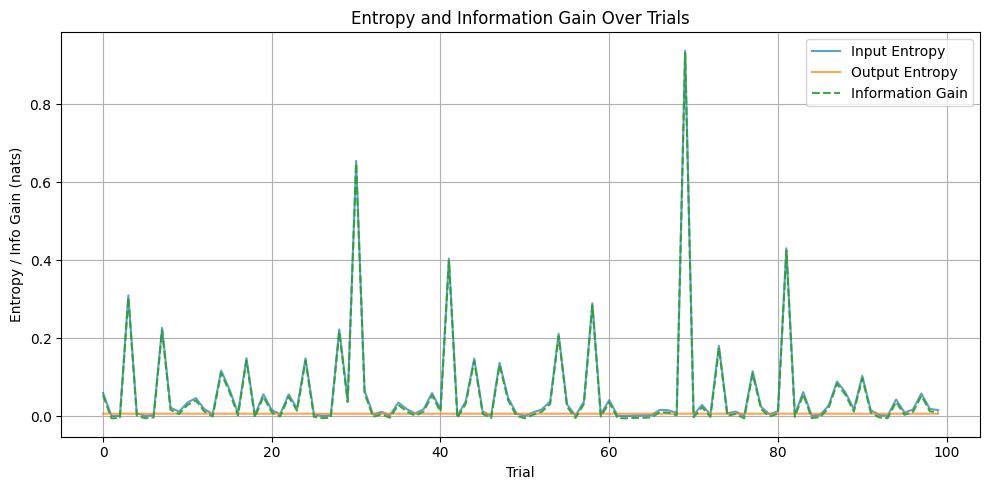

Average input entropy:  0.0637 nats
Average output entropy: 0.0061 nats
Average information gain: 0.0576 nats over 100 runs


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

# Define distance and weights
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def softmax_weights(x, sigma):
    dists = np.array([np.linalg.norm(x - p)**2 for p in patterns])
    exps = np.exp(-0.5 * dists / sigma**2)
    return exps / np.sum(exps)

# Shannon entropy
def entropy(p):
    p = np.clip(p, 1e-12, 1.0)  # avoid log(0)
    return -np.sum(p * np.log(p))

# ODE system
def memory_dynamics(t, x):
    x = np.array(x)
    w = softmax_weights(x, sigma)
    dxdt = sum(w[i] * (patterns[i] - x) for i in range(len(patterns)))
    return dxdt

# Parameters
patterns = np.array([
    [1.0, 1.0],
    [-1.0, -1.0],
    [1.0, -1.0],
    [-1.0, 1.0]
])
sigma = 0.5
N = 100  # number of runs
dt = 0.05
t_max = 10
perturb_scale = 0.4

entropy_input_list = []
entropy_output_list = []
info_gain_list = []

for _ in range(N):
    true_idx = np.random.randint(len(patterns))
    true_pattern = patterns[true_idx]
    x0 = true_pattern + np.random.normal(scale=perturb_scale, size=true_pattern.shape)

    # Entropy at input
    w_input = softmax_weights(x0, sigma)
    H_input = entropy(w_input)

    # Integrate
    solver = ode(memory_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(x0, 0)

    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)

    x_final = solver.y
    w_output = softmax_weights(x_final, sigma)
    H_output = entropy(w_output)

    entropy_input_list.append(H_input)
    entropy_output_list.append(H_output)
    info_gain_list.append(H_input - H_output)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(entropy_input_list, label='Input Entropy', alpha=0.7)
plt.plot(entropy_output_list, label='Output Entropy', alpha=0.7)
plt.plot(info_gain_list, label='Information Gain', alpha=0.9, linestyle='--')
plt.title('Entropy and Information Gain Over Trials')
plt.xlabel('Trial')
plt.ylabel('Entropy / Info Gain (nats)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Average input entropy:  {np.mean(entropy_input_list):.4f} nats")
print(f"Average output entropy: {np.mean(entropy_output_list):.4f} nats")
print(f"Average information gain: {np.mean(info_gain_list):.4f} nats over {N} runs")
